<a href="https://colab.research.google.com/github/CardiacModelling/summer-school-2025/blob/main/IonChannelModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on session 1: ion channel models
In this session, we will


*   Define a voltage clamp protocol
*   Load and run simulations for three ion channel models
*   Introduce a drug-binding component and simulate channel block.


### Step 1: Install Myokit, Sundials, import the required modules, and upload the required model files

In [ ]:
# Don't show the installation logs
%%capture
# If installation fails, comment out the line above and run again!

# Install Myokit and Sundials
!apt-get install libsundials-dev
!pip install myokit

# Disable debug messages annoyingly shown on colab
import logging
logging.disable(logging.INFO)

# Import Myokit, matplotlib and numpy
import myokit
from matplotlib import pyplot as plt
import numpy as np

!wget https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/single_gate_HH.mmt
!wget https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/two_gate_HH.mmt
!wget https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/square_MM.mmt
!wget https://raw.githubusercontent.com/CardiacModelling/summer-school-2025/refs/heads/main/resources/drug_bind_MM.mmt

After running the above code block, if the following model files don't appear in the Files section of your colab session (in the left sidebar), download them from [resources](https://github.com/CardiacModelling/summer-school-2025/tree/main/resources) in the github repo and upload them to this session.

```
single_gate_HH.mmt
two_gate_HH.mmt
square_MM.mmt
drug_bind_MM.mmt
```


### Step 2: Define and plot a voltage clamp protocol
There are several ways to define a Myokit voltage protocol. As we will be using a simple step protocol in the following examples, we can simply define it using the `Protocol()` class and the `add_step(voltage, time)` attribute.

💡 See the [Myokit documentation](https://myokit.readthedocs.io/en/stable/api_simulations/Protocol.html) for further details on Myokit protocols.

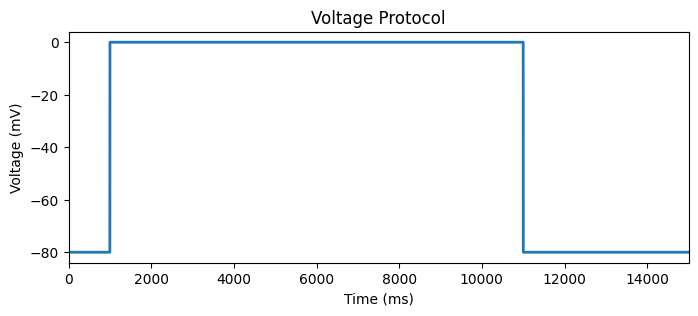

In [ ]:
# initialise a Myokit protocol
protocol = myokit.Protocol()

# add three voltage steps
protocol.add_step(-80, 1000) # start at -80mV for 1s
protocol.add_step(0, 10000) # step to 0mV for 10s
protocol.add_step(-80, 4000) # drop back down to -80mV for 4s

# define the time we wish to simulate over
max_time = 15000 # maximum time to simulate over (15s)
dt = 0.1 # step size
times = np.arange(0, max_time, dt) # use numpy to define the range of times

# get the voltages at the defined simulation times
V = protocol.value_at_times(times)

# plot the voltage protocol
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, V, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Voltage Protocol')
ax.set_ylabel('Voltage (mV)')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 3: Define a single Hodgkin-Huxley gate ion channel ODE model and run a simulation

The first ion channel model we will consider is a single Hodgkin-Huxley Closed-Open gate defined by the following set of equations:

$\frac{dO}{dt} = -k_{21}O+k_{12}C$

$\frac{dC}{dt} = k_{21}O-k_{12}C$.


Double-click on the `single_gate_HH.mmt` file in the Files sidebar to inspect the myokit model form. We can load this model with `load_model()`, and then use the `Simulation()` class to define a simulation that combines our model and protocol. The `run(duration)` attribute then allows us to run the simulation for a given time.


💡 See the [Myokit documentation](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html#) for more information on Myokit simulations.

In [ ]:
# load in the single HH gate myokit model file
single_gate_model = myokit.load_model("single_gate_HH.mmt")

# initialise myokit simulation with voltage protocol
single_gate_sim = myokit.Simulation(single_gate_model, protocol)

# run simulation and save output
single_gate_log = single_gate_sim.run(max_time, log_times=times)

### Step 4: Plot the simulated Open state probability
Next we plot the simulated Open state probability over time. Note how as the voltage steps up from -80mV to 0mV, the Open channel probability increases from 0 to 1. When the voltage drops back down to -80mV the Open probability goes back to 0 as the channel closes.

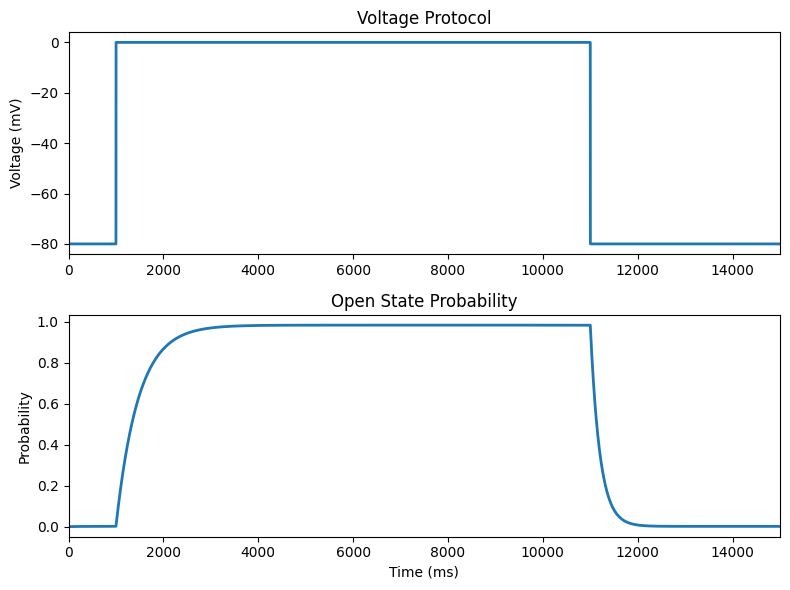

In [ ]:
# get simulated Open state probability
single_gate_O = np.array(single_gate_log['ikr.O'])

# plot the simulated Open state probability
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,6))

ax1.plot(times, V, linewidth=2)
ax1.set_xlim(0, max_time)
ax1.set_title('Voltage Protocol')
ax1.set_ylabel('Voltage (mV)')

ax2.plot(times, single_gate_O, linewidth=2)
ax2.set_xlim(0, max_time)
ax2.set_title('Open State Probability')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### Step 5: Calculate and plot the ion channel current
We can use the following equation to calculate the channel current based on the Open proportion

$I = g \cdot O \cdot (V - E)$,

where $g$ is the channel conductance, $V$ is voltage, and $E$ is the Nernst potential. The Nernst potential is calculated using the Nernst equation

$E = \frac{RT}{F}ln(\frac{k_o}{k_i})$,

where $R$ is the universal ideal gas constant, $T$ is temperature (in Kelvin), $F$ is Faraday's constant, and $k_o$ and $k_i$ are the extracellular and intracellular Potassium concentrations respectively.

✏️ **Task:** Correct the equations for the Nernst potential and channel current in the following block of code to plot the simulated current.

💡 The correct current should reach an equilibrium of $\sim13.7$pA during the 0mV step.

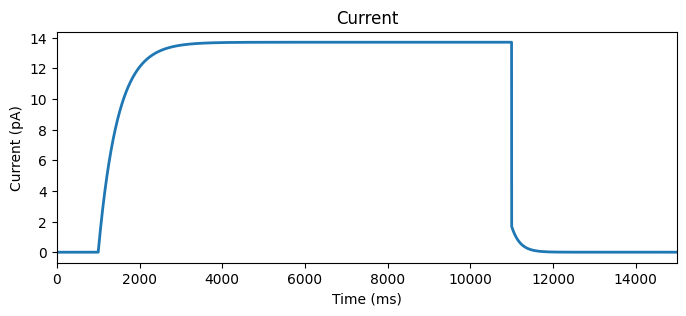

In [ ]:
# define channel conductance
g = 0.1524

# calculate Nernst potential
R = 8314 # universal ideal gas constant
T = 298.15 # temperature
F = 96485 # Faraday's constant
ko = 4 # extracellular Potassium
ki = 140 # intracellular Potassium

######## NERNST POTENTIAL #######
E = (R*T)/F * np.log(ko / ki) #CORRECT THIS
#################################

######## CHANNEL CURRENT ##################
single_gate_I = g*single_gate_O*(V-E) #CORRECT THIS
###########################################

# plot current
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, single_gate_I, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 6: Define a new Hodgkin-Huxley model with two gates and run a simulation
We will now increase the model complexity by introducing an Open-Inactive gate. Double-click on the `two_gate_HH.mmt` file to inspect the Myokit model file. The Closed-Open gate remains from the previous model (the Open state has been renamed O1 for clarity), and now there are two additional states O2 and I. Note that the Ordinary Differential Equations (ODEs) defining the O2-I gate are currently missing from the model file.

✏️ **Task:** Complete the model equations for the O2-I gate by editing `two_gate_HH.mmt`.

💡 The I$→$O2 transition rate is $k_{14}$.

💡 The O2$→$I transition rate is $k_{41}$.

💡 In a Hodkin-Huxley model, each gate has an independent set of ODEs.

Once you have completed the missing ODEs, run the below code block to load and run the two gate Hodgkin-Huxley model simulation.


In [ ]:
#load in the two HH gate myokit model file
two_gate_model = myokit.load_model("two_gate_HH.mmt")

# initialise myokit simulation with voltage protocol
two_gate_sim = myokit.Simulation(two_gate_model, protocol)

# run simulation and save output
two_gate_log = two_gate_sim.run(max_time, log_times=times)

### Step 7: Plot the simulated Open state probability
In the two-gate model, the channel is defined as being Open only when both of the independent gates are in the Open state. We can, therefore, calculate the Open state probability by taking the product of the two Open states (O1 and O2).

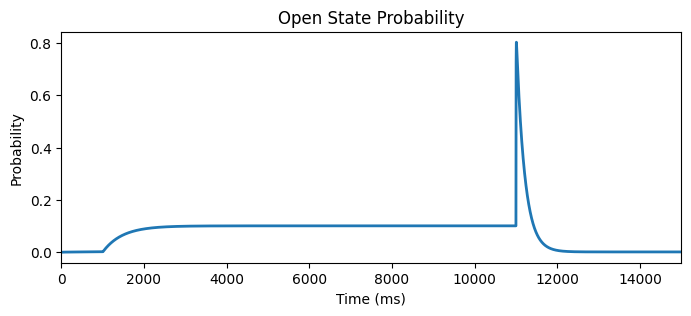

In [ ]:
# get simulated Open state probability (O1 * O2)
two_gate_O = np.array(two_gate_log['ikr.O1']) * np.array(two_gate_log['ikr.O2'])

# plot the simulated Open state probability
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, two_gate_O, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Open State Probability')
ax.set_ylabel('Probability')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 8: Calculate and plot the ion channel current
Once again, we can calculate the channel current with the following equation

$I = g \cdot O \cdot (V - E)$.



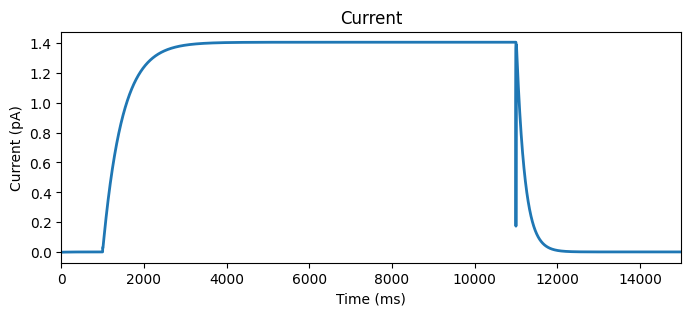

In [ ]:
# calculate current
two_gate_I = g * two_gate_O * (V - E)

# plot current
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, two_gate_I, linewidth=2)
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.show()

### Step 9: Define an equivalent four-state *square* Markov model and run a simulation

The Hodgkin-Huxley model form limits us to independent gating processes. Further modelling flexibility can be introduced by using Markov models. We will now consider a four-state *square* Markov model that is equivalent to the previously considered two-gate Hodgkin-Huxley model. Double-click on the `square_MM.mmt` file to inspect the Myokit model file. The four model states are now:


*   Open (O)
*   Closed Inactive (CI)
*   Inactive (I)
*   Closed (C).

Note that the ODE for the Inactive state ($\frac{dI}{dt}$) is currently incomplete.

✏️ **Task:** Complete the model equation for the Inactive state by editing `square_MM.mmt`.

Once you have completed the missing ODE, run the below code block to load and run the four-state Markov model simulation.

In [ ]:
# load in the square MM myokit file
square_model = myokit.load_model("square_MM.mmt")

# initialise myokit simulation with voltage protocol
square_sim = myokit.Simulation(square_model, protocol)

# run simulation and save output
square_log = square_sim.run(max_time, log_times=times)

### Step 10: Check that the current in the four-state Markov model matches the current in the two-gate Hodgkin-Huxley model
The current in the four-state Markov model should match the current in the two-gate Hodgkin-Huxley model. Run the following code to check that is the case.

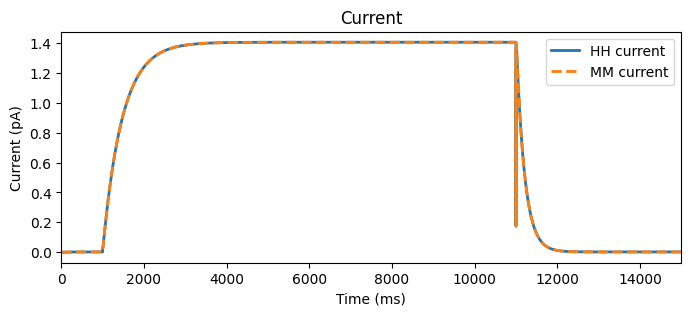

In [ ]:
# get simulated Open state probability
square_O = np.array(square_log['ikr.O'])

# calculate current
square_I = g * square_O * (V - E)

# plot current
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, two_gate_I, linewidth=2, label = 'HH current')
ax.plot(times, square_I, linestyle = '--', linewidth=2, label = 'MM current')
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.legend()
plt.show()

### Step 11: Add a drug-binding state to the Markov model
The increased flexibility of the Markov model form allows us to model drug-channel interactions. If we wish to model a drug that can bind to the channel *only* when it is in an open state, we can introduce an OD (Open Drug-bound) state. For a given drug concentration, $[D]$, hill coefficient, $h$, and on/off binding rates, $k_{on}$ and $k_{off}$, we can define the differential equation for OD as

$\frac{dOD}{dt} = k_{on}[D]^h\cdot O - k_{off}\cdot OD$

Double-click on the `drug_bind_MM.mmt` file to inspect the Myokit model file. This model intends to represent a four-state Markov model with Open state drug-binding. Note that the model equations for the O and OD states are incomplete.

✏️ **Task:** Complete the model equation for the Open and Open Drug-bound states by editing `drug_bind_MM.mmt`.

💡 The completed model should ensure that any change in the Open Drug-bound state is inversely reflected in the Open state

Once you have completed the missing ODEs, run the below code block to load and run the drug binding Markov model simulation. This code runs one simulation without a drug (i.e. $[D]=0$) and then uses `reset()` to reset the simulation before repeating with a drug compound added (i.e. $[D] = 100$).

In [ ]:
# load in the four-state MM with drug bound state myokit file
drug_bind_model = myokit.load_model("drug_bind_MM.mmt")

# initialise myokit simulation with voltage protocol
drug_bind_sim = myokit.Simulation(drug_bind_model, protocol)

# run simulation with no drug and save output
drug_bind_log_1 = drug_bind_sim.run(max_time, log_times=times)

# reset simulation
drug_bind_sim.reset()

# add drug with 100nM concentration
drug_bind_sim.set_constant('ikr.D', 100)

# run simulation with a drug and save output
drug_bind_log_2 = drug_bind_sim.run(max_time, log_times=times)


### Step 12: Plot current before and after drug added
We can calculate the channel current before and after the drug is added and plot a comparison. Note the reduction in current in the case where the drug is present.

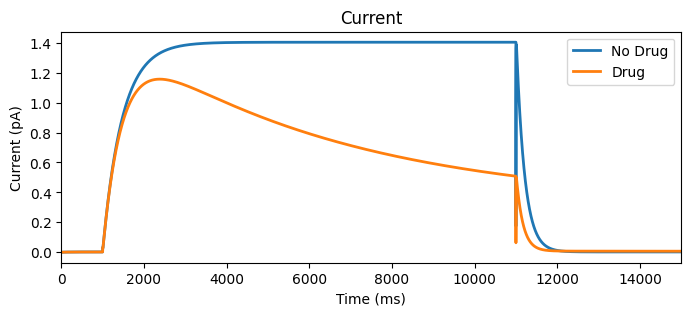

In [ ]:
# get simulated Open state probability without drug
drug_bind_O_1 = np.array(drug_bind_log_1['ikr.O'])
drug_bind_I_1 = g * drug_bind_O_1 * (V - E)

# get simulated Open state probability with drug
drug_bind_O_2 = np.array(drug_bind_log_2['ikr.O'])
drug_bind_I_2 = g * drug_bind_O_2 * (V - E)

# plot
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, drug_bind_I_1, linewidth=2, label = 'No Drug')
ax.plot(times, drug_bind_I_2, linewidth=2, label = 'Drug')
ax.set_xlim(0, max_time)
ax.set_title('Current')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (ms)')
plt.legend()
plt.show()

# Extra Tasks
✏️ Return to Step 2 and make changes to the voltage protocol. Observe how this affects the simulated Open proportion and current for each model.

✏️ Adjust the model parameters in the `.mmt` files of each model and observe how they influence the model dynamics.

✏️ Add an additional ID (Inactive Drug-bound) state and I-ID drug binding dynamics to the `drug_bind_MM.mmt` model file and observe the effects.